# Model Imports

In [37]:
import pandas as pd
import requests
import time
import seaborn as sns


# GDELT News API Data fetching 

In [38]:
# def fetch_gdelt_context(query, max_records=200, start=0):
#     base_url = "https://api.gdeltproject.org/api/v2/context/context"
    
#     params = {
#         'query': query,
#         'mode': 'artlist',
#         'format': 'json',
#         'maxrecords': max_records,
#         'start': start
#     }
    
#     try:
#         response = requests.get(base_url, params=params)
#         response.raise_for_status()  # Raise an exception for HTTP errors

#         # Parse JSON response
#         data = response.json()
#         articles = data.get('articles', [])

#         return articles

#     except requests.exceptions.RequestException as e:
#         print(f"Error fetching articles: {e}")
#         return []

# # List of topics to query
# topics = [
#     'canada'
# ]

# # number of articles to fetch
# article_count = 100000

# # Initialize DataFrame to store all articles
# all_articles_df = pd.DataFrame()

# # Fetch data for each topic
# for topic in topics:
#     start = 0
#     while True:
#         articles = fetch_gdelt_context(query=topic, max_records=200, start=start)
#         if not articles:
#             break  # Exit loop if no more articles are returned

#         # Convert list of dictionaries to DataFrame
#         articles_df = pd.DataFrame(articles)

#         # Append to the main DataFrame
#         all_articles_df = pd.concat([all_articles_df, articles_df], ignore_index=True)

#         # Break if we reach the required number of articles
#         if len(all_articles_df) >= article_count:
#             break

#         # Update start for next page
#         start += 200

#         print("Fetched total data : ",len(all_articles_df))

#         # Pause to respect API rate limits
#         time.sleep(1)

#     # Check if we have reached the required number of articles
#     if len(all_articles_df) >= article_count:
#         break

# print(f"Fetched {len(all_articles_df)} articles.")

# # Save DataFrame to CSV file
# all_articles_df.to_csv('data/gdelt_news_articles.csv', index=False)

# # Optionally, display or further process the DataFrame
# print(all_articles_df.head())


# Data Preprocessing

In [39]:
df = pd.read_csv('data/gdelt_news_articles.csv')

In [40]:
df.head()

,url,title,seendate,socialimage,domain,language,isquote,sentence,context
0,https://www.theislamicmonthly.com/from-us-to-t...,From Us to Them - The Islamic Monthly,20240616T011656Z,https://www.theislamicmonthly.com/wp-content/u...,theislamicmonthly.com,ENGLISH,0,Khalid Masood of the Westminster Bridge attack...,Journalists as well as policymakers have often...
1,https://www.castanetkamloops.net/news/Vernon/4...,Greater Vernon Chamber of Commerce looking for...,20240616T011645Z,https://www.castanet.net/content/2024/6/img_66...,castanetkamloops.net,ENGLISH,0,and Canada.,· Awareness of the business and economic clima...
2,https://calgarysun.com/news/local-news/calgary...,Everybody has to be responsible: Calgarians co...,20240616T011644Z,NaN,calgarysun.com,ENGLISH,0,Article content The bottled water was fast dis...,Or sign-in if you have an account. Article con...
3,https://calgarysun.com/news/local-news/outdoor...,Part of the family: Outdoor pet food bank open...,20240616T011644Z,NaN,calgarysun.com,ENGLISH,0,Advertisement 2 Story continues below THIS CON...,Article content A local non-profit group has o...
4,https://dynamicbusiness.com/weekly-funding-rou...,"Funding highlights: Kintsugi AI, Bailador Tech...",20240616T011643Z,https://backend.dynamicbusiness.com/wp-content...,dynamicbusiness.com,ENGLISH,0,The influx of capital will fuel Kintsugi AI's ...,Link Ventures spearheaded the series A funding...


In [41]:
df.shape

(20094, 9)

In [42]:
# selecting news only in English Languge
df = df[df['language'] == 'ENGLISH']

In [43]:
# using title only for topic modelling
df_new = df['title']

In [44]:
df_new.head()

0                From Us to Them - The Islamic Monthly
1    Greater Vernon Chamber of Commerce looking for...
2    Everybody has to be responsible: Calgarians co...
3    Part of the family: Outdoor pet food bank open...
4    Funding highlights: Kintsugi AI, Bailador Tech...
Name: title, dtype: object

In [45]:
df_new.shape

(20094,)

# Text preprocessing

In [46]:
# imports for Text preprocessing
import nltk
import gensim
from gensim import corpora
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Download NLTK resources if not already downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\umesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [47]:
# Function to map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found

# Text preprocessing for LDA
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 3]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return words

# Apply preprocessing to the 'sentence' column
df['cleaned_sentence'] = df['sentence'].apply(preprocess_text)

# Prepare for LDA
texts = df['cleaned_sentence'].tolist()


In [48]:
print(texts[:3])

[['khalid', 'masood', 'westminster', 'bridge', 'attack', 'aaron', 'driver', 'isi', 'supporter', 'detonate', 'bomb', 'ontario', 'canada', 'recent', 'example', 'concern'], ['canada'], ['article', 'content', 'bottle', 'water', 'fast', 'disappear', 'northwest', 'walmarts', 'shelf', 'wasnt', 'enough', 'quench', 'whitehot', 'anger', 'prospect', 'water', 'restriction', 'drag', 'july', 'advertisement', 'story', 'continue', 'content', 'reserve', 'subscriber', 'subscribe', 'read', 'late', 'news', 'city', 'across', 'canada']]


In [49]:
# number of words after preprocessing
print(len(texts))

20094


# Topic Modelling

In [50]:
# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

num_topic = 5
# Train LDA model
init_lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Assign topics to documents
topics = init_lda_model.get_document_topics(corpus)

# Print the topics
for idx, topic in init_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.066*"canada" + 0.023*"bank" + 0.020*"part" + 0.020*"ontario" + 0.020*"zone" + 0.020*"forest" + 0.020*"southwestern" + 0.020*"carolinian" + 0.020*"special" + 0.013*"group"
Topic: 1 
Words: 0.066*"canada" + 0.024*"say" + 0.014*"game" + 0.013*"environment" + 0.010*"article" + 0.010*"saturday" + 0.010*"south" + 0.010*"large" + 0.010*"region" + 0.010*"hail"
Topic: 2 
Words: 0.062*"canada" + 0.030*"content" + 0.025*"late" + 0.025*"across" + 0.025*"news" + 0.025*"read" + 0.025*"continue" + 0.025*"city" + 0.025*"subscriber" + 0.025*"subscribe"
Topic: 3 
Words: 0.049*"canada" + 0.036*"highway" + 0.023*"transcanada" + 0.020*"cross" + 0.013*"operation" + 0.013*"company" + 0.013*"semitrailer" + 0.010*"time" + 0.010*"state" + 0.010*"united"
Topic: 4 
Words: 0.080*"canada" + 0.033*"bank" + 0.029*"royal" + 0.021*"company" + 0.021*"united" + 0.019*"state" + 0.015*"outperform" + 0.012*"restate" + 0.012*"give" + 0.012*"price"


# Model Analysis

In [51]:
from gensim.models.coherencemodel import CoherenceModel

# Calculate Perplexity
perplexity = init_lda_model.log_perplexity(corpus)
print(f'Perplexity: {perplexity}')

# Calculate Coherence Score
coherence_init_lda = CoherenceModel(model=init_lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_init = coherence_model_lda.get_coherence()
print(f'Coherence Score of First model: {coherence_init}')


Perplexity: -5.276982665010024
Coherence Score of First model: 0.5284617340685551


# Model Improvement and Hyperparameter tuning

In [52]:
# Importing necessary libraries
import gensim
from gensim import corpora

# Create a dictionary and corpus needed for LDA
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Experimenting with different number of topics and passes
num_topics = [5, 10, 15]  # Different numbers of topics to try
passes = [10,20,30,40]  # Increase the number of passes

best_coherence = 0
best_model = None
best_num_topic = 0
for ps in passes:
    print("Passes : ", ps)
    for num in num_topics:
        # Train LDA model
        lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=num, id2word=dictionary, passes=ps, random_state=42)
        
        # Calculate Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        
        print(f'Number of Topics: {num} \tCoherence Score: {coherence_lda}')
        
        if coherence_lda > best_coherence:
            print("Best Coherence :",coherence_lda)
            best_coherence = coherence_lda
            best_model = lda_model
            best_num_topic = ps

# Print the best model's topics
for idx, topic in best_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}')


Passes :  10
Number of Topics: 5 	Coherence Score: 0.5284617340685551
Best Coherence : 0.5284617340685551
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5038813309842408
Passes :  20
Number of Topics: 5 	Coherence Score: 0.5284617340685551
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5034932287067257
Passes :  30
Number of Topics: 5 	Coherence Score: 0.5310395715625303
Best Coherence : 0.5310395715625303
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5042435822918184
Passes :  40
Number of Topics: 5 	Coherence Score: 0.5310395715625302
Number of Topics: 10 	Coherence Score: 0.47306028391920485
Number of Topics: 15 	Coherence Score: 0.5033647692298097
Topic: 0 
Words: 0.090*"canada" + 0.023*"bank" + 0.016*"ontario" + 0.016*"royal" + 0.014*"special" + 0.014*"southwestern" + 0.014*"forest" + 0.014*"carolinian" + 0.014*"zone" + 0.0

In [53]:
# Model Comparision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


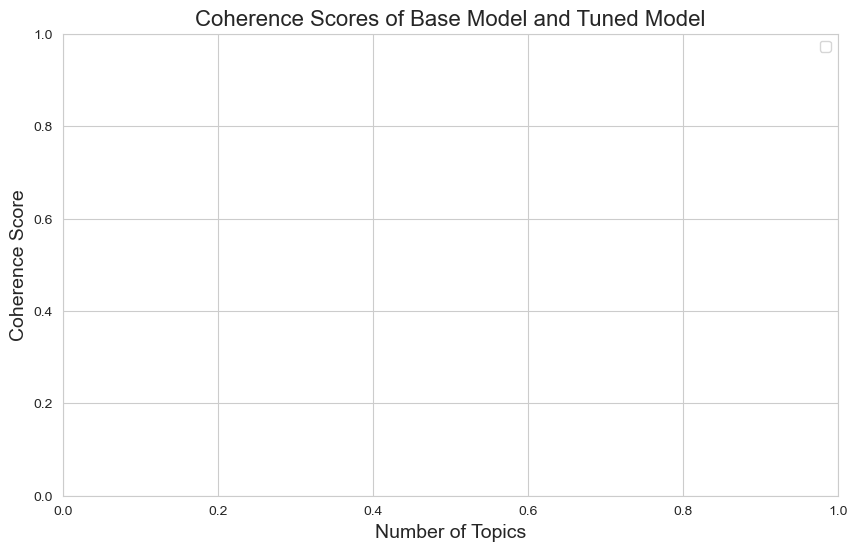

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

# Example coherence scores for different numbers of topics
# Replace these with your actual coherence scores
base_model_coherence = {
    'num_topics': [5],
    'coherence': [coherence_init_lda]
}

tuned_model_coherence = {
    'num_topics': [best_num_topic],
    'coherence': [best_coherence]
}

# Create DataFrames for the coherence scores
base_df = pd.DataFrame(base_model_coherence)
tuned_df = pd.DataFrame(tuned_model_coherence)

# Merge the DataFrames for plotting
coherence_df = base_df.merge(tuned_df, on='num_topics', suffixes=('_base', '_tuned'))

# Plot the data using Seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Line plot for the base model
sns.lineplot(x='num_topics', y='coherence_base', data=coherence_df, marker='o', label='Base Model', color='blue')

# Line plot for the tuned model
sns.lineplot(x='num_topics', y='coherence_tuned', data=coherence_df, marker='o', label='Tuned Model', color='green')

# Add labels and title
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.title('Coherence Scores of Base Model and Tuned Model', fontsize=16)
plt.legend()

# Show the plot
plt.show()


# Analysis

# Word Clouds

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to plot word cloud for a given topic
def plot_word_cloud(lda_model, topic_id, num_words=10):
    # Extract top words and their probabilities for the given topic
    topic_words = lda_model.show_topic(topic_id, topn=num_words)
    
    # Generate word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(topic_words))
    
    # Plot word cloud
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {topic_id}')
    
# Plot word clouds for all topics in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i in range(num_topics):
    plt.subplot(2, 3, i + 1)
    plot_word_cloud(lda_model, topic_id=i)

# Remove the 6th subplot (bottom-right corner)
fig.delaxes(axs[1, 2])

plt.tight_layout()
plt.show()

In [ ]:
num_topics = 5
# Aggregate topic distributions
topic_distribution = {i: 0 for i in range(num_topics)}
for doc_topics in topics:
    for topic, prob in doc_topics:
        topic_distribution[topic] += prob

# Normalize topic distribution
total_sum = sum(topic_distribution.values())
topic_distribution = {topic: prob / total_sum for topic, prob in topic_distribution.items()}

# Sort topics by probability and get top-5
top_topics = sorted(topic_distribution.items(), key=lambda x: x[1], reverse=True)[:5]

# Extract topic names based on most representative words (replace with your actual logic)
topic_names = []
for topic_id, _ in top_topics:
    topic_words = lda_model.show_topic(topic_id, topn=5)  # Adjust topn based on your preference
    topic_name = ', '.join([word for word, _ in topic_words])
    topic_names.append(topic_name)

# Plotting bar diagram with descriptive topic names
plt.figure(figsize=(10, 6))
plt.bar(topic_names, [prob for _, prob in top_topics], color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Probability')
plt.title('Top-5 Topics for News')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('top_5_topics.png') 
plt.show()

# Conclusion

# Future Improvements and Recommendations